<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/Butterfly_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Butterfly Image Segmentation**

In [1]:
#https://www.kaggle.com/datasets/veeralakrishna/butterfly-dataset

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/veeralakrishna/butterfly-dataset/butterfly-dataset.zip

In [4]:
import sys
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [5]:
img_paths = "/content/leedsbutterfly/images"
mask_paths = "/content/leedsbutterfly/segmentations"

img_paths = sorted((os.path.join(img_paths, f) for f in os.listdir(img_paths)))
mask_paths = sorted((os.path.join(mask_paths, f) for f in os.listdir(mask_paths)))


print("Total image is ::",len(img_paths))
print("Total mask is ::",len(mask_paths))

Total image is :: 832
Total mask is :: 832


In [6]:
print(img_paths[0])
print(mask_paths[0])

/content/leedsbutterfly/images/0010001.png
/content/leedsbutterfly/segmentations/0010001_seg0.png


## **Preprocessing Dataset**

In [7]:
def read_image(image_path, mask=False, img_size = 256):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)

        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[img_size, img_size])

    else:
        image = tf.image.decode_png(image, channels=3)

        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[img_size, img_size])

    return image / 255.0

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size = 32, drop_remainder=True)
    return dataset

In [8]:
dataset = data_generator(img_paths, mask_paths)

(32, 256, 256, 3)
(32, 256, 256, 1)


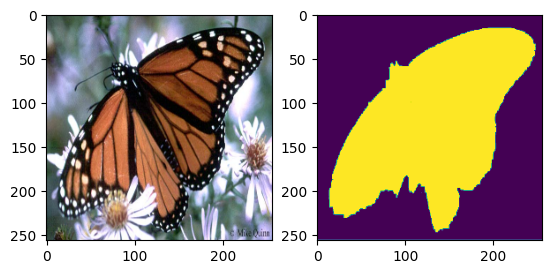

In [10]:
for img, mask in dataset.take(1):
    print(img.shape)
    print(mask.shape)


    plt.subplot(1,2,1)
    plt.imshow((img[10]*255.0).numpy().astype("uint8"))
    plt.subplot(1,2,2)
    plt.imshow(mask[10].numpy().astype("float32"))
    plt.show()
    break

## **Build UNET Model**

In [11]:
def conv_block(inputs, filters, kernel_size = 3, BatchNorm = True):
    x = layers.Conv2D(filters, kernel_size = kernel_size, padding = "same", kernel_initializer = "he_normal")(inputs)

    if BatchNorm:
        x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, kernel_size = kernel_size, padding = "same", kernel_initializer = "he_normal")(x)

    if BatchNorm:
        x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)

    return x

In [12]:
def unet_model(inputs, filters = 16, dropout_rate = 0.1, BatchNorm = True):
    c1 = conv_block(inputs, filters * 1, kernel_size = 3, BatchNorm = BatchNorm)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    c2 = conv_block(p1, filters * 2, kernel_size = 3, BatchNorm = BatchNorm)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    c3 = conv_block(p2, filters * 4, kernel_size = 3, BatchNorm = BatchNorm)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    c4 = conv_block(p3, filters * 8, kernel_size = 3, BatchNorm = BatchNorm)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(dropout_rate)(p4)

    c5 = conv_block(p4, filters * 16, kernel_size = 3, BatchNorm = BatchNorm)


    u4 = layers.Conv2DTranspose(filters * 8, kernel_size = 3, strides = 2, padding = "same")(c5)
    u4 = layers.concatenate([u4, c4])
    u4 = layers.Dropout(dropout_rate)(u4)
    u4 = conv_block(u4, filters * 8, kernel_size = 3, BatchNorm = BatchNorm)

    u3 = layers.Conv2DTranspose(filters * 4, kernel_size = 3, strides = 2, padding = "same")(u4)
    u3 = layers.concatenate([u3, c3])
    u3 = layers.Dropout(dropout_rate)(u3)
    u3 = conv_block(u3, filters * 4, kernel_size = 3, BatchNorm = BatchNorm)

    u2 = layers.Conv2DTranspose(filters * 2, kernel_size = 3, strides = 2, padding = "same")(u3)
    u2 = layers.concatenate([u2, c2])
    u2 = layers.Dropout(dropout_rate)(u2)
    u2 = conv_block(u2, filters * 8, kernel_size = 3, BatchNorm = BatchNorm)

    u1 = layers.Conv2DTranspose(filters * 1, kernel_size = 3, strides = 2, padding = "same")(u2)
    u1 = layers.concatenate([u1, c1])
    u1 = layers.Dropout(dropout_rate)(u1)
    u1 = conv_block(u1, filters * 1, kernel_size = 3, BatchNorm = BatchNorm)

    outputs = layers.Conv2D(1, kernel_size = 1, activation = "sigmoid")(u1)

    model = keras.Model(inputs, outputs)

    return model

In [13]:
inputs = keras.Input(shape = (256, 256, 3))

unet = unet_model(inputs, dropout_rate = 0.07)

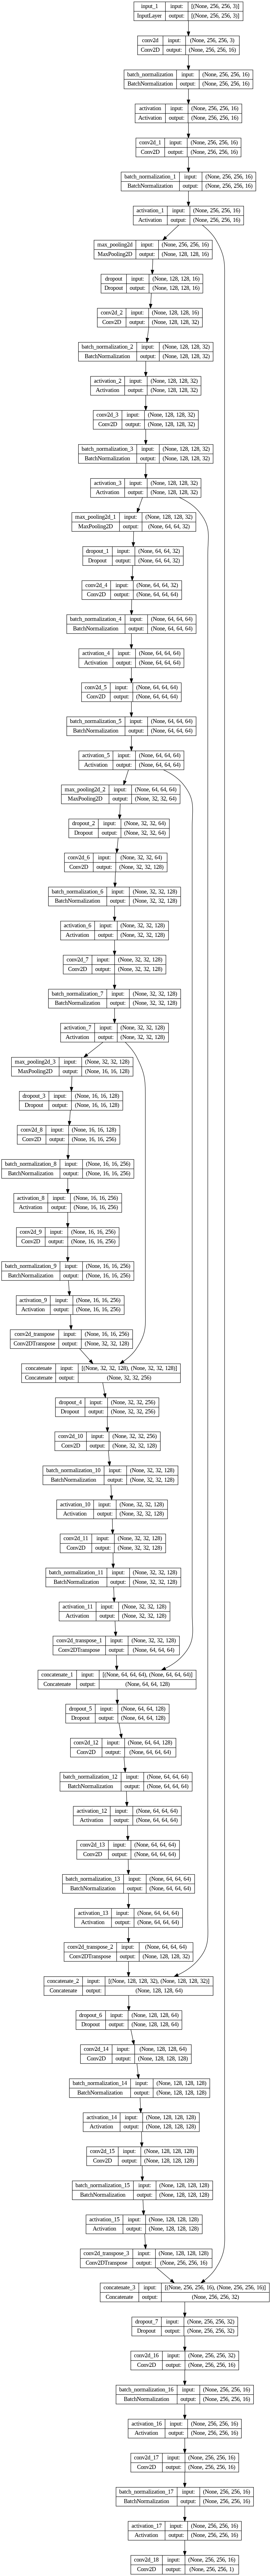

In [14]:
keras.utils.plot_model(unet, show_shapes = True, show_layer_names = True)

In [15]:
unet.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

In [16]:
history = unet.fit(dataset, epochs = 50)

Epoch 1/50
26/26 [==============================] - 51s 629ms/step - loss: 0.5294 - accuracy: 0.7597
Epoch 2/50
26/26 [==============================] - 17s 642ms/step - loss: 0.4278 - accuracy: 0.8166
Epoch 3/50
26/26 [==============================] - 19s 702ms/step - loss: 0.3662 - accuracy: 0.8437
Epoch 4/50
26/26 [==============================] - 18s 639ms/step - loss: 0.3190 - accuracy: 0.8647
Epoch 5/50
26/26 [==============================] - 17s 638ms/step - loss: 0.3035 - accuracy: 0.8678
Epoch 6/50
26/26 [==============================] - 17s 652ms/step - loss: 0.2808 - accuracy: 0.8781
Epoch 7/50
26/26 [==============================] - 17s 645ms/step - loss: 0.2678 - accuracy: 0.8824
Epoch 8/50
26/26 [==============================] - 17s 647ms/step - loss: 0.2508 - accuracy: 0.8889
Epoch 9/50
26/26 [==============================] - 18s 663ms/step - loss: 0.2383 - accuracy: 0.8929
Epoch 10/50
26/26 [==============================] - 18s 657ms/step - loss: 0.2262 - accura

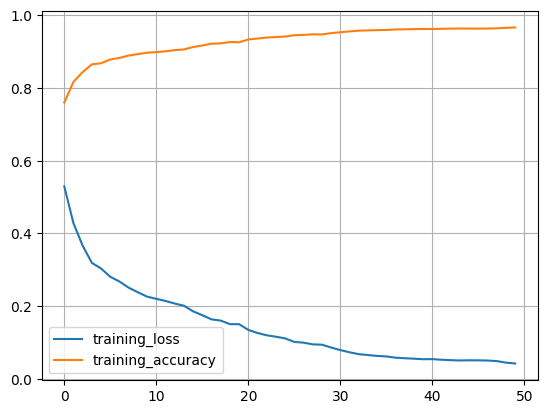

In [17]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.plot(history.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

## **Predict Model**

In [29]:
def pred_mask(dataset, model, shape = 256):
    for img, mask in dataset.take(1):
        img = img[0:16]
        mask = mask[0:16]

        img = np.array(img)
        pred = model.predict(img)

    return pred, img, mask



def plot_mask(img, pred_mask, mask):
    plt.figure(figsize=(10, 10))

    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('image')
    plt.axis("off")


    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('actual Mask')
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred_mask)
    plt.title('Predicted Mask')
    plt.axis("off")


    pred = pred_mask
    pred[pred < 0.5] = 0
    pred[pred > 0.5] = 1

    plt.subplot(1,4,4)
    plt.imshow(cv2.merge((pred, pred, pred)) * img)
    plt.title('segmented Image')
    plt.axis("off")

In [31]:
pred_mask, img, mask = pred_mask(dataset, unet)

1/1 [==============================] - 0s 31ms/step


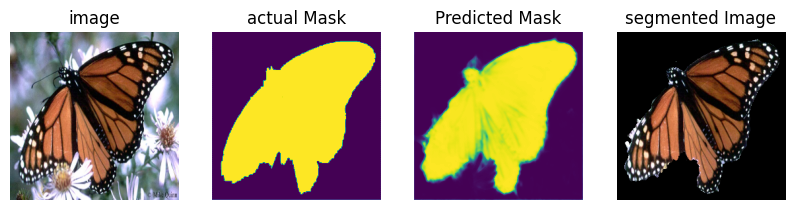

In [32]:
plot_mask(img[10], pred_mask[10][:, :, 0], mask[10])

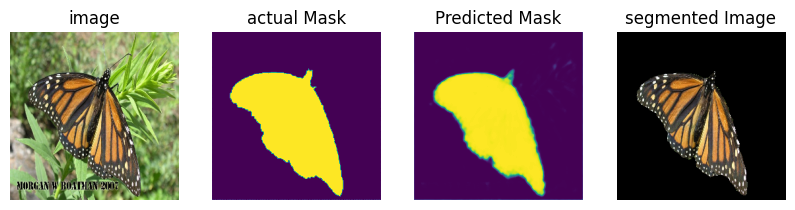

In [33]:
plot_mask(img[14], pred_mask[14][:, :, 0], mask[14])

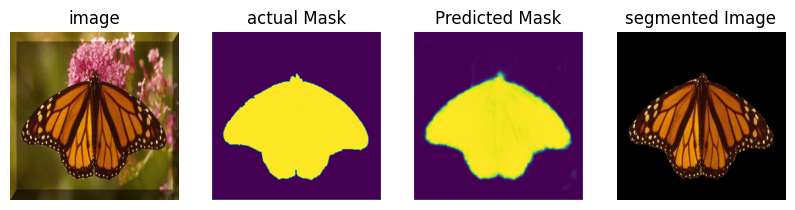

In [34]:
plot_mask(img[11], pred_mask[11][:, :, 0], mask[11])

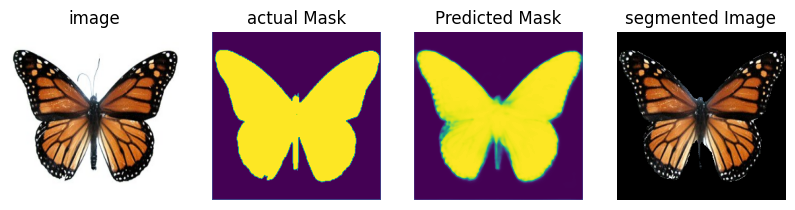

In [35]:
plot_mask(img[6], pred_mask[6][:, :, 0], mask[6])